In [1]:
!cd ~/aiffel/face_detector/widerface && ls wider_face_split  WIDER_test  WIDER_train  WIDER_val

wider_face_split:
readme.txt		      wider_face_train_bbx_gt.txt  wider_face_val.mat
wider_face_test_filelist.txt  wider_face_train.mat
wider_face_test.mat	      wider_face_val_bbx_gt.txt

WIDER_test:
images

WIDER_train:
images

WIDER_val:
images


In [2]:
!cd ~/aiffel/face_detector/widerface/wider_face_split && head -20 wider_face_train_bbx_gt.txt

0--Parade/0_Parade_marchingband_1_849.jpg
1
449 330 122 149 0 0 0 0 0 0 
0--Parade/0_Parade_Parade_0_904.jpg
1
361 98 263 339 0 0 0 0 0 0 
0--Parade/0_Parade_marchingband_1_799.jpg
21
78 221 7 8 2 0 0 0 0 0 
78 238 14 17 2 0 0 0 0 0 
113 212 11 15 2 0 0 0 0 0 
134 260 15 15 2 0 0 0 0 0 
163 250 14 17 2 0 0 0 0 0 
201 218 10 12 2 0 0 0 0 0 
182 266 15 17 2 0 0 0 0 0 
245 279 18 15 2 0 0 0 0 0 
304 265 16 17 2 0 0 0 2 1 
328 295 16 20 2 0 0 0 0 0 
389 281 17 19 2 0 0 0 2 0 
406 293 21 21 2 0 1 0 0 0 


1. SSD 모델 만들고 얼굴에 BOUNDING BOX 만들기

In [2]:
import os, cv2, time
import tensorflow as tf
import tqdm
import numpy as np
import math
from itertools import product
import matplotlib.pyplot as plt

PROJECT_PATH = os.getenv('HOME')+'/aiffel/face_detector'
DATA_PATH = os.path.join(PROJECT_PATH, 'widerface')
MODEL_PATH = os.path.join(PROJECT_PATH, 'checkpoints')
TRAIN_TFRECORD_PATH = os.path.join(PROJECT_PATH, 'dataset', 'train_mask.tfrecord')
VALID_TFRECORD_PATH = os.path.join(PROJECT_PATH, 'dataset', 'val_mask.tfrecord')
CHECKPOINT_PATH = os.path.join(PROJECT_PATH, 'checkpoints')

DATASET_LEN = 12880
BATCH_SIZE = 32
IMAGE_WIDTH = 320
IMAGE_HEIGHT = 256
IMAGE_LABELS = ['background', 'face']

print(tf.__version__)

2.6.0


In [2]:
def parse_box(data):
    x0 = int(data[0])
    y0 = int(data[1])
    w = int(data[2])
    h = int(data[3])
    return x0, y0, w, h

In [3]:
def parse_widerface(file):
    infos = []
    with open(file) as fp:
        line = fp.readline()
        while line:
            n_object = int(fp.readline())
            boxes = []
            for i in range(n_object):
                box = fp.readline().split(' ')
                x0, y0, w, h = parse_box(box)
                if (w == 0) or (h == 0):
                    continue
                boxes.append([x0, y0, w, h])
            if n_object == 0:
                box = fp.readline().split(' ')
                x0, y0, w, h = parse_box(box)
                boxes.append([x0, y0, w, h])
            infos.append((line.strip(), boxes))
            line = fp.readline()
    return infos

In [4]:
def process_image(image_file):
    image_string = tf.io.read_file(image_file)
    try:
        image_data = tf.image.decode_jpeg(image_string, channels = 3)
        return 0, image_string, image_data
    except tf.errors.InvalidArgumentError:
        return 1, image_tring, None

In [5]:
def xywh_to_voc(file_name, boxes, image_data):
    shape = image_data.shape
    image_info = {}
    image_info['filename'] = file_name
    image_info['width'] = shape[1]
    image_info['height'] = shape[0]
    image_info['depth'] = 3
    
    difficult = []
    classes = []
    xmin, ymin, xmax, ymax = [], [], [], []
    
    for box in boxes:
        classes.append(1)
        difficult.append(0)
        xmin.append(box[0])
        ymin.append(box[1])
        xmax.append(box[0] + box[2])
        ymax.append(box[1] + box[3])
    image_info['class'] = classes
    image_info['xmin'] = xmin
    image_info['ymin'] = ymin
    image_info['xmax'] = xmax
    image_info['ymax'] = ymax
    image_info['difficult'] = difficult
    
    return image_info


 이미지별 boxes 리스트에 담긴 bounding box 정보확인

In [6]:
file_path = os.path.join(DATA_PATH, 'wider_face_split', 'wider_face_train_bbx_gt.txt')
for i, info in enumerate(parse_widerface(file_path)):
    print('--------------------')
    image_file = os.path.join(DATA_PATH, 'WIDER_train', 'images', info[0])
    _, image_string, image_data = process_image(image_file)
    boxes = xywh_to_voc(image_file, info[1], image_data)
    print(boxes)
    if i > 3:
        break

--------------------
{'filename': '/aiffel/aiffel/face_detector/widerface/WIDER_train/images/0--Parade/0_Parade_marchingband_1_849.jpg', 'width': 1024, 'height': 1385, 'depth': 3, 'class': [1], 'xmin': [449], 'ymin': [330], 'xmax': [571], 'ymax': [479], 'difficult': [0]}
--------------------
{'filename': '/aiffel/aiffel/face_detector/widerface/WIDER_train/images/0--Parade/0_Parade_Parade_0_904.jpg', 'width': 1024, 'height': 1432, 'depth': 3, 'class': [1], 'xmin': [361], 'ymin': [98], 'xmax': [624], 'ymax': [437], 'difficult': [0]}
--------------------
{'filename': '/aiffel/aiffel/face_detector/widerface/WIDER_train/images/0--Parade/0_Parade_marchingband_1_799.jpg', 'width': 1024, 'height': 768, 'depth': 3, 'class': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'xmin': [78, 78, 113, 134, 163, 201, 182, 245, 304, 328, 389, 406, 436, 522, 643, 653, 793, 535, 29, 3, 20], 'ymin': [221, 238, 212, 260, 250, 218, 266, 279, 265, 295, 281, 293, 290, 328, 320, 224, 337, 311, 22

TFRecord 만들기
- TensorFlow만의 학습 데이터 저장 포맷
- 이진(binary) 레코드의 시퀀스 저장

In [7]:
def make_example(image_string, image_infos):
    for info in image_infos:
        filename = info['filename']
        width = info['width']
        height = info['height']
        depth = info['depth']
        classes = info['class']
        xmin = info['xmin']
        ymin = info['ymin']
        xmax = info['xmax']
        ymax = info['ymax']
    
    if isinstance(image_string,type(tf.constant(0))):
        encoded_image = [image_string.numpy()]
    else:
        encoded_image = [image_string]
        
    base_name = [tf.compat.as_bytes(os.path.basename(filename))]
    
    example = tf.train.Example(features=tf.train.Features(feature={
        'filename':tf.train.Feature(bytes_list=tf.train.BytesList(value=base_name)),
        'height':tf.train.Feature(int64_list=tf.train.Int64List(value=[height])),
        'width':tf.train.Feature(int64_list=tf.train.Int64List(value=[width])),
        'classes':tf.train.Feature(int64_list=tf.train.Int64List(value=classes)),
        'x_mins':tf.train.Feature(float_list=tf.train.FloatList(value=xmin)),
        'y_mins':tf.train.Feature(float_list=tf.train.FloatList(value=ymin)),
        'x_maxes':tf.train.Feature(float_list=tf.train.FloatList(value=xmax)),
        'y_maxes':tf.train.Feature(float_list=tf.train.FloatList(value=ymax)),
        'image_raw':tf.train.Feature(bytes_list=tf.train.BytesList(value=encoded_image))
    }))
    
    return example

In [8]:
for split in ['train', 'val']:
    if split == 'train':
        output_file = TRAIN_TFRECORD_PATH
        anno_txt = 'wider_face_train_bbx_gt.txt'
        file_path = 'WIDER_train'
    else:
        output_file = VALID_TFRECORD_PATH
        anno_txt = 'wider_face_val_bbx_gt.txt'
        file_path = 'WIDER_val'
        
    with tf.io.TFRecordWriter(output_file) as writer:
        for info in tqdm.tqdm(parse_widerface(os.path.join(DATA_PATH, 'wider_face_split', anno_txt))):
            image_file = os.path.join(DATA_PATH, file_path, 'images', info[0])
            error, image_string, image_data = process_image(image_file)
            boxes = xywh_to_voc(image_file, info[1], image_data)

            if not error:
                tf_example = make_example(image_string, [boxes])
                writer.write(tf_example.SerializeToString())    

100%|██████████| 3226/3226 [00:18<00:00, 175.02it/s]


In [9]:
BOX_MIN_SIZES = [[10, 16, 24], [32, 48], [64, 96], [128, 192, 256]]
BOX_STEPS = [8, 16, 32, 64]

In [10]:
image_sizes = (IMAGE_HEIGHT, IMAGE_WIDTH)
min_sizes = BOX_MIN_SIZES
steps= BOX_STEPS

feature_maps = [
    [math.ceil(image_sizes[0] / step), math.ceil(image_sizes[1] / step)]
    for step in steps
]
feature_maps


[[32, 40], [16, 20], [8, 10], [4, 5]]

In [11]:
boxes = []
for k, f in enumerate(feature_maps):
    for i, j in product(range(f[0]), range(f[1])):
        for min_size in min_sizes[k]:
            s_kx = min_size / image_sizes[1]
            s_ky = min_size / image_sizes[0]
            cx = (j + 0.5) * steps[k] / image_sizes[1]
            cy = (i + 0.5) * steps[k] / image_sizes[0]
            boxes += [cx, cy, s_kx, s_ky]

len(boxes)

18800

In [12]:
pretty_boxes = np.asarray(boxes).reshape([-1, 4])
print(pretty_boxes.shape)
print(pretty_boxes)

(4700, 4)
[[0.0125    0.015625  0.03125   0.0390625]
 [0.0125    0.015625  0.05      0.0625   ]
 [0.0125    0.015625  0.075     0.09375  ]
 ...
 [0.9       0.875     0.4       0.5      ]
 [0.9       0.875     0.6       0.75     ]
 [0.9       0.875     0.8       1.       ]]


In [13]:
def default_box():
    image_sizes = (IMAGE_HEIGHT, IMAGE_WIDTH)
    min_sizes = BOX_MIN_SIZES
    steps= BOX_STEPS
    feature_maps = [
        [math.ceil(image_sizes[0] / step), math.ceil(image_sizes[1] / step)]
        for step in steps
    ]
    boxes = []
    for k, f in enumerate(feature_maps):
        for i, j in product(range(f[0]), range(f[1])):
            for min_size in min_sizes[k]:
                s_kx = min_size / image_sizes[1]
                s_ky = min_size / image_sizes[0]
                cx = (j + 0.5) * steps[k] / image_sizes[1]
                cy = (i + 0.5) * steps[k] / image_sizes[0]
                boxes += [cx, cy, s_kx, s_ky]
    boxes = np.asarray(boxes).reshape([-1, 4])
    return boxes


In [14]:
def _conv_block(inputs, filters, kernel=(3, 3), strides=(1, 1)):
    block_id = (tf.keras.backend.get_uid())
    if strides == (2, 2):
        x = tf.keras.layers.ZeroPadding2D(padding=((1, 1), (1, 1)), name='conv_pad_%d' % block_id)(inputs)
        x = tf.keras.layers.Conv2D(filters, kernel,
                                   padding='valid',
                                   use_bias=False,
                                   strides=strides,
                                   name='conv_%d' % block_id)(x)
    else:
        x = tf.keras.layers.Conv2D(filters, kernel,
                                   padding='same',
                                   use_bias=False,
                                   strides=strides,
                                   name='conv_%d' % block_id)(inputs)
    
    x = tf.keras.layers.BatchNormalization(name='conv_bn_%d' % block_id)(x)
    return tf.keras.layers.ReLU(name='conv_relu_%d' % block_id)(x)


In [15]:
def _depthwise_conv_block(inputs, filters, strides=(1, 1)):
    block_id = tf.keras.backend.get_uid()
    if strides == (1, 1):
        x = inputs
    else:
        x = tf.keras.layers.ZeroPadding2D(((1, 1), (1, 1)), name='conv_pad_%d' % block_id)(inputs)
    x = tf.keras.layers.DepthwiseConv2D((3, 3),
                                        padding='same' if strides == (1, 1) else 'valid',
                                        strides=strides,
                                        use_bias=False,
                                        name='conv_dw_%d' % block_id)(x)
    x = tf.keras.layers.BatchNormalization(name='conv_dw_%d_bn' % block_id)(x)
    x = tf.keras.layers.ReLU(name='conv_dw_%d_relu' % block_id)(x)
    x = tf.keras.layers.Conv2D(filters, (1, 1),
                               padding='same',
                               use_bias=False,
                               strides=(1, 1),
                               name='conv_pw_%d' % block_id)(x)
    x = tf.keras.layers.BatchNormalization(name='conv_pw_%d_bn' % block_id)(x)
    return tf.keras.layers.ReLU(name='conv_pw_%d_relu' % block_id)(x)


In [16]:
def _branch_block(inputs, filters):
    x = tf.keras.layers.Conv2D(filters, kernel_size=(3, 3), padding='same')(inputs)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.Conv2D(filters, kernel_size=(3, 3), padding='same')(x)
    x1 = tf.keras.layers.Conv2D(filters * 2, kernel_size=(3, 3), padding='same')(inputs)
    x = tf.keras.layers.Concatenate(axis=-1)([x, x1])
    return tf.keras.layers.ReLU()(x)

In [17]:
def _create_head_block(inputs, filters):
    x = tf.keras.layers.Conv2D(filters, kernel_size=(3, 3), strides=(1, 1), padding='same')(inputs)
    return x

In [18]:
def _compute_heads(inputs, num_class, num_cell):
    conf = _create_head_block(inputs, num_cell * num_class)
    conf = tf.keras.layers.Reshape((-1, num_class))(conf)
    loc = _create_head_block(inputs, num_cell * 4)
    loc = tf.keras.layers.Reshape((-1, 4))(loc)
    return conf, loc

In [19]:
def SsdModel():
    base_channel = 16
    num_cells = [3, 2, 2, 3]
    num_class = len(IMAGE_LABELS)
    
    x = inputs = tf.keras.layers.Input(shape=[IMAGE_HEIGHT, IMAGE_WIDTH, 3], name='input_image')

    x = _conv_block(x, base_channel, strides=(2, 2))
    x = _conv_block(x, base_channel * 2, strides=(1, 1))
    x = _conv_block(x, base_channel * 2, strides=(2, 2))
    x = _conv_block(x, base_channel * 2, strides=(1, 1))
    x = _conv_block(x, base_channel * 4, strides=(2, 2))
    x = _conv_block(x, base_channel * 4, strides=(1, 1))
    x = _conv_block(x, base_channel * 4, strides=(1, 1))
    x = _conv_block(x, base_channel * 4, strides=(1, 1))
    x1 = _branch_block(x, base_channel)

    x = _conv_block(x, base_channel * 8, strides=(2, 2))
    x = _conv_block(x, base_channel * 8, strides=(1, 1))
    x = _conv_block(x, base_channel * 8, strides=(1, 1))
    x2 = _branch_block(x, base_channel)

    x = _depthwise_conv_block(x, base_channel * 16, strides=(2, 2))
    x = _depthwise_conv_block(x, base_channel * 16, strides=(1, 1))
    x3 = _branch_block(x, base_channel)

    x = _depthwise_conv_block(x, base_channel * 16, strides=(2, 2))
    x4 = _branch_block(x, base_channel)

    extra_layers = [x1, x2, x3, x4]

    confs = []
    locs = []

    for layer, num_cell in zip(extra_layers, num_cells):
        conf, loc = _compute_heads(layer, num_class, num_cell)
        confs.append(conf)
        locs.append(loc)

    confs = tf.keras.layers.Concatenate(axis=1, name="face_classes")(confs)
    locs = tf.keras.layers.Concatenate(axis=1, name="face_boxes")(locs)

    predictions = tf.keras.layers.Concatenate(axis=2, name='predictions')([locs, confs])

    model = tf.keras.Model(inputs=inputs, outputs=predictions, name='ssd_model')
    return model


In [20]:
model = SsdModel()
print("the number of model layers: ", len(model.layers))
model.summary()

the number of model layers:  101
Model: "ssd_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        [(None, 256, 320, 3) 0                                            
__________________________________________________________________________________________________
conv_pad_1 (ZeroPadding2D)      (None, 258, 322, 3)  0           input_image[0][0]                
__________________________________________________________________________________________________
conv_1 (Conv2D)                 (None, 128, 160, 16) 432         conv_pad_1[0][0]                 
__________________________________________________________________________________________________
conv_bn_1 (BatchNormalization)  (None, 128, 160, 16) 64          conv_1[0][0]                     
_________________________________________________________

In [21]:
import tensorflow as tf

def YourSsdModel():
    base_channel = 16
    # 기본 박스(cell)의 개수와 클래스 개수 정의
    num_cells = [3, 2, 2, 3]  # 각 특징 맵에서 기본 박스 개수
    num_class = len(IMAGE_LABELS)  # 클래스 개수 (예: 20개 클래스 + 배경 클래스)
    
    # 입력 이미지 크기 정의 (예: 300x300 크기의 3채널 이미지)
    x= inputs = tf.keras.Input(shape=[IMAGE_HEIGHT, IMAGE_WIDTH, 3], name="image_input")
    
    x = _conv_block(x, base_channel, strides=(2, 2))
    x = _conv_block(x, base_channel * 2, strides=(1, 1))
    x = _conv_block(x, base_channel * 2, strides=(2, 2))
    x = _conv_block(x, base_channel * 2, strides=(1, 1))
    x = _conv_block(x, base_channel * 4, strides=(2, 2))
    x = _conv_block(x, base_channel * 4, strides=(1, 1))
    x = _conv_block(x, base_channel * 4, strides=(1, 1))
    x = _conv_block(x, base_channel * 4, strides=(1, 1))
    x1 = _branch_block(x, base_channel)
    
    x = _conv_block(x, base_channel * 8, strides=(2, 2))
    x = _conv_block(x, base_channel * 8, strides=(1, 1))
    x = _conv_block(x, base_channel * 8, strides=(1, 1))
    x2 = _branch_block(x, base_channel)    
    
    # SSD에 필요한 추가 레이어 생성
    x = _depthwise_conv_block(x, base_channel * 16, strides=(2, 2))
    x = _depthwise_conv_block(x, base_channel * 16, strides=(1, 1))
    x3 = _branch_block(x, base_channel)

    x = _depthwise_conv_block(x, base_channel * 16, strides=(2, 2))
    x4 = _branch_block(x, base_channel)
    
    # SSD 헤드 계산을 위한 특징 맵 리스트
    extra_layers = [x1, x2, x3, x4]    

    
    # SSD 헤드(Confidence, Localization) 생성
    confs = []  # 클래스 예측 결과
    locs = []   # 위치 정보 예측 결과
    
    for layer, num_cell in zip(extra_layers, num_cells):
        conf, loc = _compute_heads(layer, num_class, num_cell)
        confs.append(conf)
        locs.append(loc)

       
    # 모든 특징 맵에서 나온 Confidence와 Localization 결과를 연결
    confs = tf.keras.layers.Concatenate(axis=1, name="face_classes")(confs)
    locs = tf.keras.layers.Concatenate(axis=1, name="face_boxes")(locs)
    
    # 최종 예측 결과(위치 + 클래스)를 합침
    predictions = tf.keras.layers.Concatenate(axis=2, name="predictions")([locs, confs])
    
    # SSD 모델 생성
    model = tf.keras.Model(inputs=inputs, outputs=predictions, name="ssd_model")
    return model

# 예제 사용
model = YourSsdModel()
model.summary()

Model: "ssd_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image_input (InputLayer)        [(None, 256, 320, 3) 0                                            
__________________________________________________________________________________________________
conv_pad_15 (ZeroPadding2D)     (None, 258, 322, 3)  0           image_input[0][0]                
__________________________________________________________________________________________________
conv_15 (Conv2D)                (None, 128, 160, 16) 432         conv_pad_15[0][0]                
__________________________________________________________________________________________________
conv_bn_15 (BatchNormalization) (None, 128, 160, 16) 64          conv_15[0][0]                    
__________________________________________________________________________________________

In [22]:
def _crop(img, labels, max_loop=250):
    shape = tf.shape(img)

    def matrix_iof(a, b):
        lt = tf.math.maximum(a[:, tf.newaxis, :2], b[:, :2])
        rb = tf.math.minimum(a[:, tf.newaxis, 2:], b[:, 2:])

        area_i = tf.math.reduce_prod(rb - lt, axis=2) * \
            tf.cast(tf.reduce_all(lt < rb, axis=2), tf.float32)
        area_a = tf.math.reduce_prod(a[:, 2:] - a[:, :2], axis=1)
        return area_i / tf.math.maximum(area_a[:, tf.newaxis], 1)

    def crop_loop_body(i, img, labels):
        valid_crop = tf.constant(1, tf.int32)

        pre_scale = tf.constant([0.3, 0.45, 0.6, 0.8, 1.0], dtype=tf.float32)
        scale = pre_scale[tf.random.uniform([], 0, 5, dtype=tf.int32)]
        short_side = tf.cast(tf.minimum(shape[0], shape[1]), tf.float32)
        h = w = tf.cast(scale * short_side, tf.int32)
        h_offset = tf.random.uniform([], 0, shape[0] - h + 1, dtype=tf.int32)
        w_offset = tf.random.uniform([], 0, shape[1] - w + 1, dtype=tf.int32)
        roi = tf.stack([w_offset, h_offset, w_offset + w, h_offset + h])
        roi = tf.cast(roi, tf.float32)

        value = matrix_iof(labels[:, :4], roi[tf.newaxis])
        valid_crop = tf.cond(tf.math.reduce_any(value >= 1),
                             lambda: valid_crop, lambda: 0)

        centers = (labels[:, :2] + labels[:, 2:4]) / 2
        mask_a = tf.reduce_all(
            tf.math.logical_and(roi[:2] < centers, centers < roi[2:]),
            axis=1)
        labels_t = tf.boolean_mask(labels, mask_a)
        valid_crop = tf.cond(tf.reduce_any(mask_a),
                             lambda: valid_crop, lambda: 0)

        img_t = img[h_offset:h_offset + h, w_offset:w_offset + w, :]
        h_offset = tf.cast(h_offset, tf.float32)
        w_offset = tf.cast(w_offset, tf.float32)
        labels_t = tf.stack(
            [labels_t[:, 0] - w_offset,  labels_t[:, 1] - h_offset,
             labels_t[:, 2] - w_offset,  labels_t[:, 3] - h_offset,
             labels_t[:, 4]], axis=1)

        return tf.cond(valid_crop == 1,
                       lambda: (max_loop, img_t, labels_t),
                       lambda: (i + 1, img, labels))

    _, img, labels = tf.while_loop(
        lambda i, img, labels: tf.less(i, max_loop),
        crop_loop_body,
        [tf.constant(-1), img, labels],
        shape_invariants=[tf.TensorShape([]),
                          tf.TensorShape([None, None, 3]),
                          tf.TensorShape([None, 5])])

    return img, labels


In [23]:
def _resize(img, labels):
    w_f = tf.cast(tf.shape(img)[1], tf.float32)
    h_f = tf.cast(tf.shape(img)[0], tf.float32)
    locs = tf.stack([labels[:, 0] / w_f,  labels[:, 1] / h_f,
                     labels[:, 2] / w_f,  labels[:, 3] / h_f] ,axis=1)
    locs = tf.clip_by_value(locs, 0, 1.0)
    labels = tf.concat([locs, labels[:, 4][:, tf.newaxis]], axis=1)

    resize_case = tf.random.uniform([], 0, 5, dtype=tf.int32)

    def resize(method):
        def _resize():
            #　size h,w
            return tf.image.resize(img, [IMAGE_HEIGHT, IMAGE_WIDTH], method=method, antialias=True)
        return _resize

    img = tf.case([(tf.equal(resize_case, 0), resize('bicubic')),
                   (tf.equal(resize_case, 1), resize('area')),
                   (tf.equal(resize_case, 2), resize('nearest')),
                   (tf.equal(resize_case, 3), resize('lanczos3'))],
                  default=resize('bilinear'))

    return img, labels


In [24]:
def _flip(img, labels):
    flip_case = tf.random.uniform([], 0, 2, dtype=tf.int32)

    def flip_func():
        flip_img = tf.image.flip_left_right(img)
        flip_labels = tf.stack([1 - labels[:, 2],  labels[:, 1],
                                1 - labels[:, 0],  labels[:, 3],
                                labels[:, 4]], axis=1)

        return flip_img, flip_labels

    img, labels = tf.case([(tf.equal(flip_case, 0), flip_func)],default=lambda: (img, labels))

    return img, labels


_pad_to_square
: 이미지가 정사각형이 되도록 이미지 오른쪽이나 아래 방향으로 평균 색상 영역을 추가

In [25]:
def _pad_to_square(img):
    height = tf.shape(img)[0]
    width = tf.shape(img)[1]

    def pad_h():
        img_pad_h = tf.ones([width - height, width, 3]) * tf.reduce_mean(img, axis=[0, 1], keepdims=True)
        return tf.concat([img, img_pad_h], axis=0)

    def pad_w():
        img_pad_w = tf.ones([height, height - width, 3]) * tf.reduce_mean(img, axis=[0, 1], keepdims=True)
        return tf.concat([img, img_pad_w], axis=1)

    img = tf.case([(tf.greater(height, width), pad_w),
                   (tf.less(height, width), pad_h)], default=lambda: img)
    return img


Distort - 이미지 색상값만 변경

In [26]:
def _distort(img):
    img = tf.image.random_brightness(img, 0.4)
    img = tf.image.random_contrast(img, 0.5, 1.5)
    img = tf.image.random_saturation(img, 0.5, 1.5)
    img = tf.image.random_hue(img, 0.1)

    return img


Jaccard 유사도
 - 디폴트박스와 바운딩박스를 비교하여 서로 얼마나 유사한지 측정하는 지표
 - 두집합의 합으로 두집합의 교집합을 나눠줌. 
 - 0과 1사이의 값을 가짐

In [27]:
def _intersect(box_a, box_b):
    A = tf.shape(box_a)[0]
    B = tf.shape(box_b)[0]
    max_xy = tf.minimum(
        tf.broadcast_to(tf.expand_dims(box_a[:, 2:], 1), [A, B, 2]),
        tf.broadcast_to(tf.expand_dims(box_b[:, 2:], 0), [A, B, 2]))
    min_xy = tf.maximum(
        tf.broadcast_to(tf.expand_dims(box_a[:, :2], 1), [A, B, 2]),
        tf.broadcast_to(tf.expand_dims(box_b[:, :2], 0), [A, B, 2]))
    inter = tf.clip_by_value(max_xy - min_xy, 0.0, 512.0)
    return inter[:, :, 0] * inter[:, :, 1]


In [28]:
def _jaccard(box_a, box_b):
    inter = _intersect(box_a, box_b)
    area_a = tf.broadcast_to(
        tf.expand_dims(
            (box_a[:, 2] - box_a[:, 0]) * (box_a[:, 3] - box_a[:, 1]), 1),
        tf.shape(inter))  # [A,B]
    area_b = tf.broadcast_to(
        tf.expand_dims(
            (box_b[:, 2] - box_b[:, 0]) * (box_b[:, 3] - box_b[:, 1]), 0),
        tf.shape(inter))  # [A,B]
    union = area_a + area_b - inter
    return inter / union  # [A,B]


In [29]:
def _encode_bbox(matched, boxes, variances=[0.1, 0.2]):
    g_cxcy = (matched[:, :2] + matched[:, 2:]) / 2 - boxes[:, :2]
    g_cxcy /= (variances[0] * boxes[:, 2:])
    g_wh = (matched[:, 2:] - matched[:, :2]) / boxes[:, 2:]
    g_wh = tf.math.log(g_wh) / variances[1]
    g_wh = tf.where(tf.math.is_inf(g_wh), 0.0, g_wh)
    return tf.concat([g_cxcy, g_wh], 1)

In [30]:
def encode_tf(labels, boxes):
    match_threshold = 0.45
    boxes = tf.cast(boxes, tf.float32)
    bbox = labels[:, :4]
    conf = labels[:, -1]
   
    # jaccard index
    overlaps = _jaccard(bbox, boxes)
    best_box_overlap = tf.reduce_max(overlaps, 1)
    best_box_idx = tf.argmax(overlaps, 1, tf.int32)

    best_truth_overlap = tf.reduce_max(overlaps, 0)
    best_truth_idx = tf.argmax(overlaps, 0, tf.int32)

    best_truth_overlap = tf.tensor_scatter_nd_update(
        best_truth_overlap, tf.expand_dims(best_box_idx, 1),
        tf.ones_like(best_box_idx, tf.float32) * 2.)
    best_truth_idx = tf.tensor_scatter_nd_update(
        best_truth_idx, tf.expand_dims(best_box_idx, 1),
        tf.range(tf.size(best_box_idx), dtype=tf.int32))
    # Scale Ground-Truth Boxes   
    matches_bbox = tf.gather(bbox, best_truth_idx)
    loc_t = _encode_bbox(matches_bbox, boxes)
    conf_t = tf.gather(conf, best_truth_idx)
    conf_t = tf.where(tf.less(best_truth_overlap, match_threshold), tf.zeros_like(conf_t), conf_t)

    return tf.concat([loc_t, conf_t[..., tf.newaxis]], axis=1)


load_dataset

In [31]:
def _transform_data(train, boxes):
    def transform_data(img, labels):
        img = tf.cast(img, tf.float32)
        if train:
            img, labels = _crop(img, labels)
            img = _pad_to_square(img)

        img, labels = _resize(img, labels)

        if train:
            img, labels = _flip(img, labels)

        if train:
            img = _distort(img)
        labels = encode_tf(labels, boxes)        
        img = img/255.0
        return img, labels
    return transform_data


In [32]:
def _parse_tfrecord(train, boxes):
    def parse_tfrecord(tfrecord):
        features = {
            'filename': tf.io.FixedLenFeature([], tf.string),
            'height': tf.io.FixedLenFeature([], tf.int64),
            'width': tf.io.FixedLenFeature([], tf.int64),
            'classes': tf.io.VarLenFeature(tf.int64),
            'x_mins': tf.io.VarLenFeature(tf.float32),
            'y_mins': tf.io.VarLenFeature(tf.float32),
            'x_maxes': tf.io.VarLenFeature(tf.float32),
            'y_maxes': tf.io.VarLenFeature(tf.float32),
            'difficult':tf.io.VarLenFeature(tf.int64),
            'image_raw': tf.io.FixedLenFeature([], tf.string),
           }

        parsed_example = tf.io.parse_single_example(tfrecord, features)
        img = tf.image.decode_jpeg(parsed_example['image_raw'], channels=3)

        width = tf.cast(parsed_example['width'], tf.float32)
        height = tf.cast(parsed_example['height'], tf.float32)

        labels = tf.sparse.to_dense(parsed_example['classes'])
        labels = tf.cast(labels, tf.float32)

        labels = tf.stack(
            [tf.sparse.to_dense(parsed_example['x_mins']),
             tf.sparse.to_dense(parsed_example['y_mins']),
             tf.sparse.to_dense(parsed_example['x_maxes']),
             tf.sparse.to_dense(parsed_example['y_maxes']),labels], axis=1)

        img, labels = _transform_data(train, boxes)(img, labels)

        return img, labels
    return parse_tfrecord


In [33]:
def load_tfrecord_dataset(tfrecord_name, train=True, boxes=None, buffer_size=1024):
    raw_dataset = tf.data.TFRecordDataset(tfrecord_name)
    raw_dataset = raw_dataset.cache()
    if train:
        raw_dataset = raw_dataset.repeat()
        raw_dataset = raw_dataset.shuffle(buffer_size=buffer_size)

    dataset = raw_dataset.map(_parse_tfrecord(train, boxes), num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return dataset

In [34]:
def load_dataset(boxes, train=True, buffer_size=1024):
    if train:
        dataset = load_tfrecord_dataset(
            tfrecord_name=TRAIN_TFRECORD_PATH,
            train=train,
            boxes=boxes,
            buffer_size=buffer_size)
    else:
        dataset = load_tfrecord_dataset(
            tfrecord_name=VALID_TFRECORD_PATH,
            train=train,
            boxes=boxes,
            buffer_size=buffer_size)
    return dataset


Learning rate scheduler

In [35]:
class PiecewiseConstantWarmUpDecay(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, boundaries, values, warmup_steps, min_lr, name=None):
        super(PiecewiseConstantWarmUpDecay, self).__init__()

        if len(boundaries) != len(values) - 1:
            raise ValueError(
                    "The length of boundaries should be 1 less than the"
                    "length of values")

        self.boundaries = boundaries
        self.values = values
        self.name = name
        self.warmup_steps = warmup_steps
        self.min_lr = min_lr

    def __call__(self, step):
        with tf.name_scope(self.name or "PiecewiseConstantWarmUp"):
            step = tf.cast(tf.convert_to_tensor(step), tf.float32)
            pred_fn_pairs = []
            warmup_steps = self.warmup_steps
            boundaries = self.boundaries
            values = self.values
            min_lr = self.min_lr

            pred_fn_pairs.append(
                (step <= warmup_steps,
                 lambda: min_lr + step * (values[0] - min_lr) / warmup_steps))
            pred_fn_pairs.append(
                (tf.logical_and(step <= boundaries[0],
                                step > warmup_steps),
                 lambda: tf.constant(values[0])))
            pred_fn_pairs.append(
                (step > boundaries[-1], lambda: tf.constant(values[-1])))

            for low, high, v in zip(boundaries[:-1], boundaries[1:],
                                    values[1:-1]):
                pred = (step > low) & (step <= high)
                pred_fn_pairs.append((pred, lambda: tf.constant(v)))

            return tf.case(pred_fn_pairs, lambda: tf.constant(values[0]),
                           exclusive=True)


In [36]:
def MultiStepWarmUpLR(initial_learning_rate, lr_steps, lr_rate,
                      warmup_steps=0., min_lr=0.,
                      name='MultiStepWarmUpLR'):
    assert warmup_steps <= lr_steps[0]
    assert min_lr <= initial_learning_rate
    lr_steps_value = [initial_learning_rate]
    for _ in range(len(lr_steps)):
        lr_steps_value.append(lr_steps_value[-1] * lr_rate)
    return PiecewiseConstantWarmUpDecay(
        boundaries=lr_steps, values=lr_steps_value, warmup_steps=warmup_steps,
        min_lr=min_lr)

Hard negative mining

In [37]:
def hard_negative_mining(loss, class_truth, neg_ratio):
    pos_idx = class_truth > 0
    num_pos = tf.math.reduce_sum(tf.cast(pos_idx, tf.int32), axis=1)
    num_neg = num_pos * neg_ratio

    rank = tf.argsort(loss, axis=1, direction='DESCENDING')
    rank = tf.argsort(rank, axis=1)
    neg_idx = rank < tf.expand_dims(num_neg, 1)

    return pos_idx, neg_idx


In [38]:
def MultiBoxLoss(num_class, neg_pos_ratio=3.0):
    def multi_loss(y_true, y_pred):
        num_batch = tf.shape(y_true)[0]
        loc_pred, class_pred = y_pred[..., :4], y_pred[..., 4:]
        loc_truth, class_truth = y_true[..., :4], tf.squeeze(y_true[..., 4:])

        cross_entropy = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')
        temp_loss = cross_entropy(class_truth, class_pred)
        pos_idx, neg_idx = hard_negative_mining(temp_loss, class_truth, neg_pos_ratio)

        cross_entropy = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='sum')
        loss_class = cross_entropy(
            class_truth[tf.math.logical_or(pos_idx, neg_idx)],
            class_pred[tf.math.logical_or(pos_idx, neg_idx)])
        
        smooth_l1_loss = tf.keras.losses.Huber(reduction='sum')
        loss_loc = smooth_l1_loss(loc_truth[pos_idx],loc_pred[pos_idx])

        num_pos = tf.math.reduce_sum(tf.cast(pos_idx, tf.float32))

        loss_class = loss_class / num_pos
        loss_loc = loss_loc / num_pos
        return loss_loc, loss_class

    return multi_loss


Training

In [39]:
boxes = default_box()
train_dataset = load_dataset(boxes, train=True)

Model: "ssd_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        [(None, 256, 320, 3) 0                                            
__________________________________________________________________________________________________
conv_pad_29 (ZeroPadding2D)     (None, 258, 322, 3)  0           input_image[0][0]                
__________________________________________________________________________________________________
conv_29 (Conv2D)                (None, 128, 160, 16) 432         conv_pad_29[0][0]                
__________________________________________________________________________________________________
conv_bn_29 (BatchNormalization) (None, 128, 160, 16) 64          conv_29[0][0]                    
__________________________________________________________________________________________

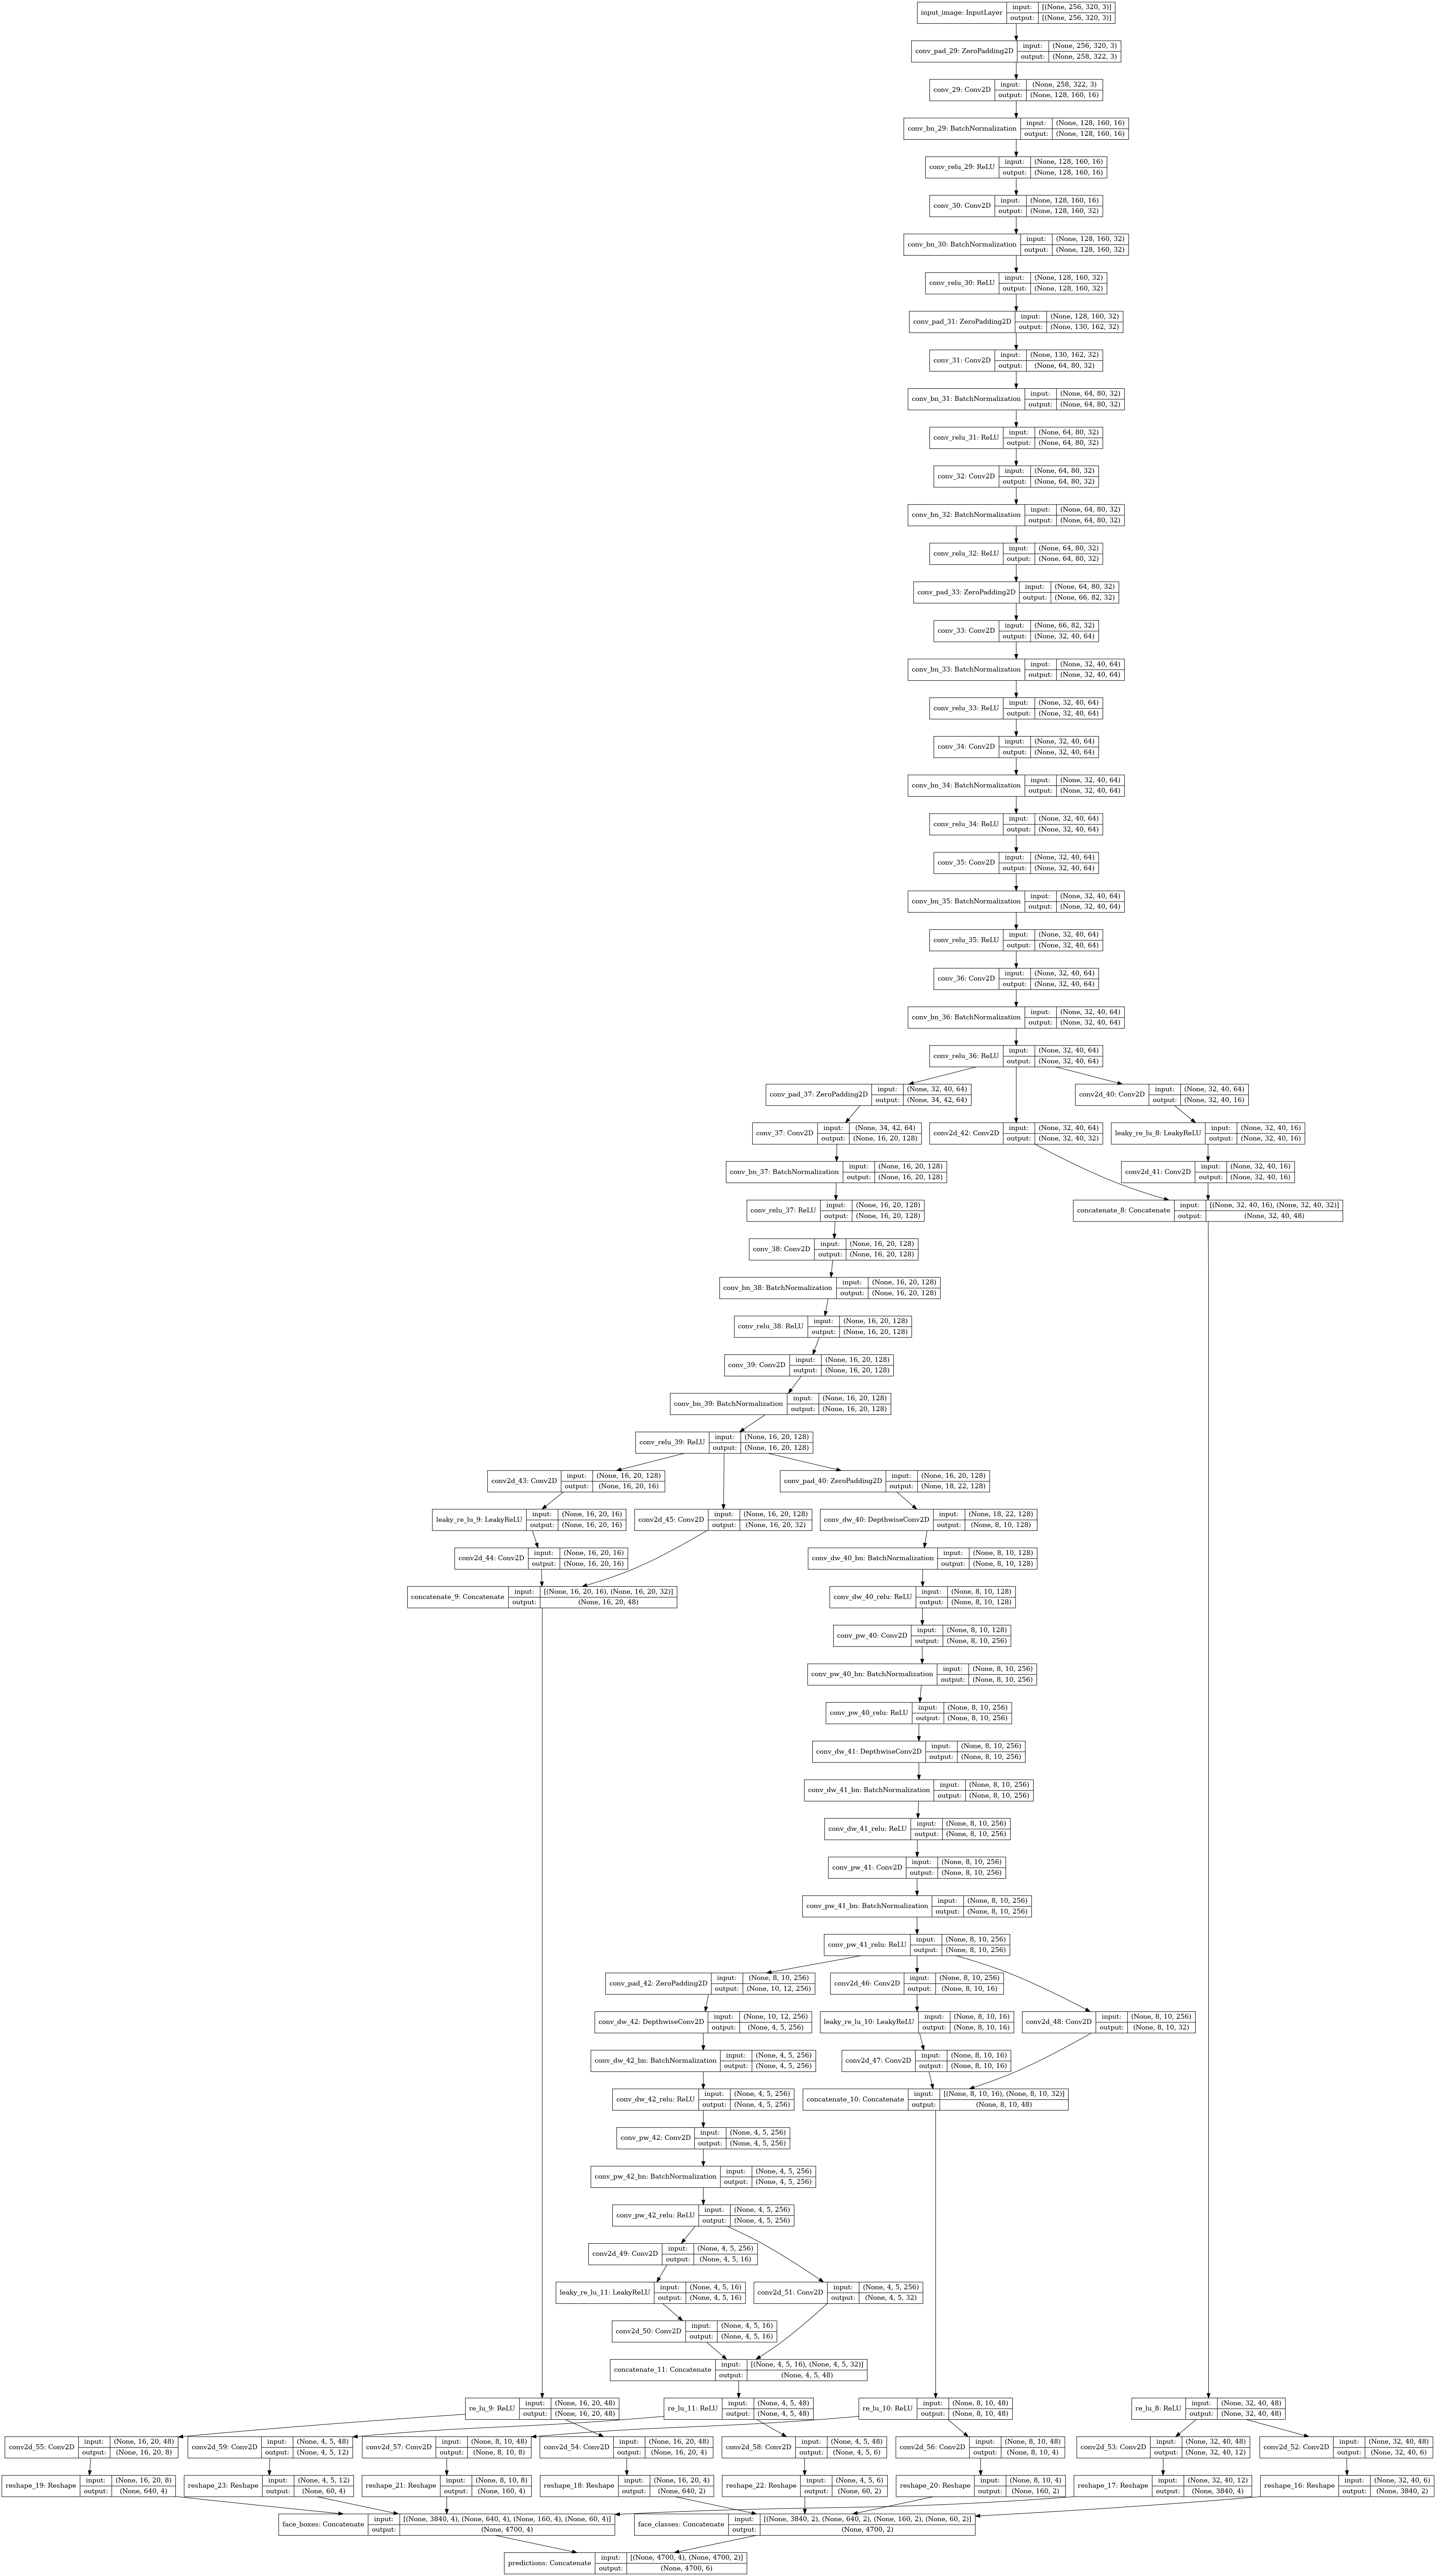

In [40]:
model = SsdModel()
model.summary()
tf.keras.utils.plot_model(
    model, 
    to_file=os.path.join(os.getcwd(), 'model.png'),
    show_shapes=True, 
    show_layer_names=True
)

In [41]:
steps_per_epoch = DATASET_LEN // BATCH_SIZE
learning_rate = MultiStepWarmUpLR(
    initial_learning_rate=1e-2,
    lr_steps=[e*steps_per_epoch for e in [50, 70]],
    lr_rate=0.1,
    warmup_steps=5*steps_per_epoch,
    min_lr=1e-4
)
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9, nesterov=True)

multi_loss = MultiBoxLoss(len(IMAGE_LABELS), neg_pos_ratio=3)


In [42]:
@tf.function
def train_step(inputs, labels):
    with tf.GradientTape() as tape:
        predictions = model(inputs, training=True)
        losses = {}
        losses['reg'] = tf.reduce_sum(model.losses)  #unused. Init for redefine network
        losses['loc'], losses['class'] = multi_loss(labels, predictions)
        total_loss = tf.add_n([l for l in losses.values()])

    grads = tape.gradient(total_loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

    return total_loss, losses

In [43]:
# EPOCHS = 30

# for epoch in range(0, EPOCHS):
#     for step, (inputs, labels) in enumerate(train_dataset.take(steps_per_epoch)):
#         load_t0 = time.time()
#         total_loss, losses = train_step(inputs, labels)
#         load_t1 = time.time()
#         batch_time = load_t1 - load_t0
#         print(f"\rEpoch: {epoch + 1}/{EPOCHS} | Batch {step + 1}/{steps_per_epoch} | Batch time {batch_time:.3f} || Loss: {total_loss:.6f} | loc loss:{losses['loc']:.6f} | class loss:{losses['class']:.6f} ",end = '',flush=True)
        
# epoch_loss /= steps_per_epoch  # 에포크 평균 손실 계산
# print(f"\nEpoch {epoch + 1} Average Loss: {epoch_loss:.6f}")

# # 모델 가중치 저장
# model.save_weights(f'weights/weights_epoch_{epoch + 1}.h5')

In [126]:
EPOCHS = 50

for epoch in range(0, EPOCHS):
    for step, (inputs, labels) in enumerate(train_dataset.take(steps_per_epoch)):
        load_t0 = time.time()
        total_loss, losses = train_step(inputs, labels)
        load_t1 = time.time()
        batch_time = load_t1 - load_t0
        print(f"\rEpoch: {epoch + 1}/{EPOCHS} | Batch {step + 1}/{steps_per_epoch} | Batch time {batch_time:.3f} || Loss: {total_loss:.6f} | loc loss:{losses['loc']:.6f} | class loss:{losses['class']:.6f} ",end = '',flush=True)
        
epoch_loss /= steps_per_epoch  # 에포크 평균 손실 계산
print(f"\nEpoch {epoch + 1} Average Loss: {epoch_loss:.6f}")

# 모델 가중치 저장
model.save_weights(f'weights/weights_epoch_{epoch + 1}.h5')

Epoch: 50/50 | Batch 402/402 | Batch time 0.058 || Loss: 5.950289 | loc loss:5.023048 | class loss:0.927241  
Epoch 50 Average Loss: 0.000045


NMS구현하기

In [44]:
def compute_nms(boxes, scores, nms_threshold=0.4, limit=200):
    if boxes.shape[0] == 0:
        return tf.constant([], dtype=tf.int32)
    selected = [0]
    idx = tf.argsort(scores, direction='DESCENDING')
    idx = idx[:limit]
    boxes = tf.gather(boxes, idx)

    iou = _jaccard(boxes, boxes)

    while True:
        row = iou[selected[-1]]
        next_indices = row <= nms_threshold

        iou = tf.where(
            tf.expand_dims(tf.math.logical_not(next_indices), 0),
            tf.ones_like(iou, dtype=tf.float32),
            iou
        )

        if not tf.math.reduce_any(next_indices):
            break

        selected.append(tf.argsort(
            tf.dtypes.cast(next_indices, tf.int32), direction='DESCENDING')[0].numpy())

    return tf.gather(idx, selected)

NMS후 Bounding Box 구하기

In [45]:
def decode_bbox_tf(predicts, boxes, variances=[0.1, 0.2]):
    centers = boxes[:, :2] + predicts[:, :2] * variances[0] * boxes[:, 2:]
    sides = boxes[:, 2:] * tf.math.exp(predicts[:, 2:] * variances[1])
    return tf.concat([centers - sides / 2, centers + sides / 2], axis=1)

In [46]:
def parse_predict(predictions, boxes):
    label_classes = IMAGE_LABELS

    bbox_predictions, confidences = tf.split(predictions[0], [4, -1], axis=-1)
    boxes = decode_bbox_tf(bbox_predictions, boxes)

    scores = tf.math.softmax(confidences, axis=-1)

    out_boxes = []
    out_labels = []
    out_scores = []

    for c in range(1, len(label_classes)):
        cls_scores = scores[:, c]

        score_idx = cls_scores > 0.5

        cls_boxes = boxes[score_idx]
        cls_scores = cls_scores[score_idx]

        nms_idx = compute_nms(cls_boxes, cls_scores)

        cls_boxes = tf.gather(cls_boxes, nms_idx)
        cls_scores = tf.gather(cls_scores, nms_idx)

        cls_labels = [c] * cls_boxes.shape[0]

        out_boxes.append(cls_boxes)
        out_labels.extend(cls_labels)
        out_scores.append(cls_scores)

    out_boxes = tf.concat(out_boxes, axis=0)
    out_scores = tf.concat(out_scores, axis=0)

    boxes = tf.clip_by_value(out_boxes, 0.0, 1.0).numpy()
    classes = np.array(out_labels)
    scores = out_scores.numpy()

    return boxes, classes, scores

사진에서 여러 얼굴찾기

In [47]:
def pad_input_image(img, max_steps):
    img_h, img_w, _ = img.shape

    img_pad_h = 0
    if img_h % max_steps > 0:
        img_pad_h = max_steps - img_h % max_steps

    img_pad_w = 0
    if img_w % max_steps > 0:
        img_pad_w = max_steps - img_w % max_steps

    padd_val = np.mean(img, axis=(0, 1)).astype(np.uint8)
    img = cv2.copyMakeBorder(img, 0, img_pad_h, 0, img_pad_w,
                             cv2.BORDER_CONSTANT, value=padd_val.tolist())
    pad_params = (img_h, img_w, img_pad_h, img_pad_w)

    return img, pad_params

In [48]:
def recover_pad(boxes, pad_params):
    img_h, img_w, img_pad_h, img_pad_w = pad_params
    box = np.reshape(boxes[0], [-1, 2, 2]) * [(img_pad_w + img_w) / img_w, (img_pad_h + img_h) / img_h]
    boxes[0] = np.reshape(box, [-1, 4])
    return boxes

In [49]:
def draw_box_on_face(img, boxes, classes, scores, box_index, class_list):
    img_height = img.shape[0]
    img_width = img.shape[1]

    x_min = int(boxes[box_index][0] * img_width)
    y_min = int(boxes[box_index][1] * img_height)
    x_max = int(boxes[box_index][2] * img_width)
    y_max = int(boxes[box_index][3] * img_height)

    if classes[box_index] == 1:
        color = (0, 255, 0)
    else:
        color = (0, 0, 255)
    cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color, 2)
    
    if len(scores) > box_index :
        score = "{:.4f}".format(scores[box_index])
        class_name = class_list[classes[box_index]]
        label = '{} {}'.format(class_name, score)
        position = (x_min, y_min - 4) 
        cv2.putText(img, label, position, cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255))

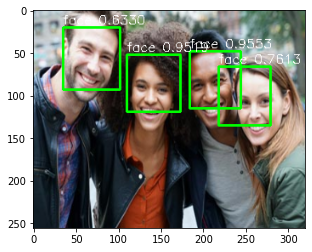

In [50]:
# weights_epoch을 바꿔야지.....
filepath = os.path.join(PROJECT_PATH, 'weights', 'weights_epoch_30.h5')
model.load_weights(filepath)

TEST_IMAGE_PATH = os.path.join(PROJECT_PATH, 'image_people.png')

img_raw = cv2.imread(TEST_IMAGE_PATH)
img_raw = cv2.resize(img_raw, (IMAGE_WIDTH, IMAGE_HEIGHT))
img = np.float32(img_raw.copy())

img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img, pad_params = pad_input_image(img, max_steps=max(BOX_STEPS))
img = img / 255.0

boxes = default_box()
boxes = tf.cast(boxes, tf.float32)

predictions = model.predict(img[np.newaxis, ...])

pred_boxes, labels, scores = parse_predict(predictions, boxes)
pred_boxes = recover_pad(pred_boxes, pad_params)

for box_index in range(len(pred_boxes)):
    draw_box_on_face(img_raw, pred_boxes, labels, scores, box_index, IMAGE_LABELS)

plt.imshow(cv2.cvtColor(img_raw, cv2.COLOR_BGR2RGB))
plt.show()

2. Dlib 활용히여 landmark localization

In [52]:
# 추가적으로 필요한 패키지 업데이트 또는 인스톨하기
!pip install --upgrade dlib
!apt-get update
!apt-get install -y cmake
!pip install dlib

     |████████████████████████████████| 3.4 MB 3.9 MB/s            
  Preparing metadata (setup.py) ... done
  Created wheel for dlib: filename=dlib-19.24.6-cp39-cp39-linux_x86_64.whl size=4123750 sha256=578e03574e84fdef50a0567c600f216acad0aa5e5a68b59dd36c46cfa07b23c0
  Stored in directory: /aiffel/.cache/pip/wheels/f5/ba/ea/ad13d4a963e5dbbbaf4dce5fef93353e2e7586ba8b7787221c
Successfully built dlib
  Attempting uninstall: dlib
    Found existing installation: dlib 19.22.1
    Uninstalling dlib-19.22.1:
      Successfully uninstalled dlib-19.22.1
Hit:1 http://archive.ubuntu.com/ubuntu focal InRelease
Get:2 http://archive.ubuntu.com/ubuntu focal-updates InRelease [128 kB]
Get:3 http://security.ubuntu.com/ubuntu focal-security InRelease [128 kB]
Get:4 http://archive.ubuntu.com/ubuntu focal-backports InRelease [128 kB]
Get:5 http://archive.ubuntu.com/ubuntu focal-updates/multiverse amd64 Packages [34.6 kB]
Get:6 http://archive.ubuntu.com/ubuntu focal-updates/main amd64 Packages [4,639 kB]


In [60]:
!pip install dlib opencv-python

In [63]:
!pip install opencv-python dlib

In [3]:
import cv2
import dlib

# 얼굴을 감지하는 기능인 detector를 선언합니다
detector_hog = dlib.get_frontal_face_detector() # 기본 얼굴 감지기를 반환

# 저장한 landmark 모델의 주소를 model_path 변수에 저장
model_path = 'shape_predictor_68_face_landmarks.dat'

print(os.path.exists(model_path))

landmark_predictor = dlib.shape_predictor(model_path)

True


True
/aiffel/aiffel/face_detector


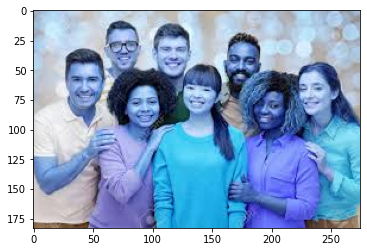

In [4]:
# people 이미지 가져오기

my_image_path = 'people.jpg' # 본인 이미지가 있는 경로를 가지고 온다.
print(os.path.exists(my_image_path))
print(os.getcwd())
img_bgr = cv2.imread(my_image_path)    # OpenCV로 이미지를 불러옵니다
img_show = img_bgr.copy()      # 출력용 이미지를 따로 보관합니다
plt.imshow(img_bgr) # 이미지를 출력하기 위해 출력할 이미지를 올려준다. (실제 출력은 하지 않음)
plt.show() # 이미지를 출력해준다. (실제 출력)

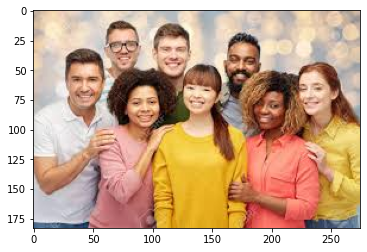

In [5]:
# plt.imshow 이전에 RGB 이미지로 바꾸는 것을 잊지마세요.
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb) # 이미지 실제 출력하기 위해 이미지를 올려줌
plt.show() # 이미지 실제 출력

2.1 이미지 얼굴위에 박싱하기

In [6]:
# 얼굴을 감지하는 기능인 detector를 선언합니다
detector_hog = dlib.get_frontal_face_detector() # 기본 얼굴 감지기를 반환

In [7]:
# dlib을 사용하여 rgb 이미지를 입력으로 받기 때문에 cvtColor() 를 이용해서 opencv 의 bgr 이미지를 rgb로 변환
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
dlib_rects = detector_hog(img_rgb, 1)   # (image, num of image pyramid), '1'의 의미는 이미지를 원본크기 그대로 사용한다는 의미

2.1.1 얼굴의 영역 찾아 Boxing하기

rectangles[[(25, 50) (61, 86)], [(73, 66) (109, 102)], [(157, 30) (193, 66)], [(213, 50) (249, 86)], [(121, 54) (157, 90)], [(57, 18) (93, 54)], [(97, 22) (133, 58)]]


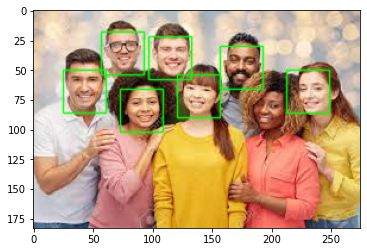

In [8]:
# 여러 얼굴이 있을 수 있으므로 찾은 얼굴 영역 박스 리스트화 함.
# 각 rectangle(x1, y1, x2, y2)는 탐지된 얼굴의 경계 상자입니다.
# x1, y1: 사각형의 왼쪽 위 좌표
# x2, y2: 사각형의 오른쪽 아래 좌표
print(dlib_rects)
# 결과: rectangles[[(485, 1508) (1635, 2658)]] 처음 좌표는 사각형 왼쪽 위, 두번째 좌표는 사각형 오른쪽 아래

for dlib_rect in dlib_rects: # 찾은 얼굴 영역의 좌표
    l = dlib_rect.left() # 왼쪽
    t = dlib_rect.top() # 위쪽
    r = dlib_rect.right() # 오른쪽 
    b = dlib_rect.bottom() # 아래쪽

    # 시작점의 좌표와 종료점 좌표로 직각 사각형을 그림 - Boxing 생성
    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 1, lineType=cv2.LINE_AA)

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

2.2 Dlib landmark localization
- 사각형 테두리 안에서 이목구비 찾기
- 얼굴의 68개 랜드마크를 가진 모델 적용

In [9]:
# 저장한 landmark 모델의 주소를 model_path 변수에 저장
model_path = 'shape_predictor_68_face_landmarks.dat'

print(os.path.exists(model_path))

landmark_predictor = dlib.shape_predictor(model_path)
# dlib 라이브러리의 shape_predictor 함수를 이용하여 모델을 불러옴
# landmark_predictor는 RGB이미지와 dlib.rectangle를 입력 받고 dlib.full_object_detection를 반환
# dlib.rectangle: 내부를 예측하는 박스
# dlib.full_object_detection: 각 구성 요소의 위치와, 이미지 상의 객체의 위치를 나타냄

True


In [10]:
# 랜드마크의 위치를 저장할 list 생성
list_landmarks = []


# 얼굴 영역 박스 마다 face landmark를 찾아냅니다
# face landmark 좌표를 저장해둡니다
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
        # 모든 landmark의 위치정보를 points 변수에 저장
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
        # 각각의 landmark 위치정보를 (x,y) 형태로 변환하여 list_points 리스트로 저장
    list_landmarks.append(list_points)
        # list_landmarks에 랜드마크 리스트를 저장

print(len(list_landmarks[0]))
    # 얼굴이 n개인 경우 list_landmarks는 n개의 원소를 갖고
    # 각 원소는 68개의 랜드마크 위치가 나열된 list
    # list_landmarks의 원소가 1개이므로 list_landmarks[1]을 호출하면 IndexError가 발생

68


2.3 이미지내 얼굴 랜드마크 Detection하고 점으로 표시

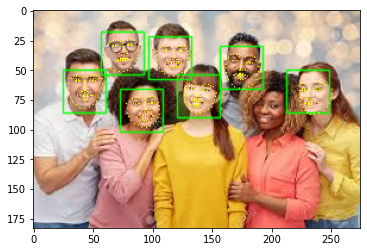

In [11]:
# list_landmarks의 원소가 1개이므로 아래 반복문은 한번만 실행됨
for landmark in list_landmarks:
    for point in landmark:
        cv2.circle(img_show, point, 0, (0, 255, 255), -1)
            # cv2.circle: OpenCV의 원을 그리는 함수
            # img_show 이미지 위 각각의 point에
            # 크기가 2이고 (0, 255, 255)색으로 내부가 채워진(-1) 원을 그림
            # (마지막 인수가 자연수라면 그만큼의 두께의 선으로 원이 그려짐)

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
    # RGB 이미지로 전환
plt.imshow(img_show_rgb)
    # 이미지를 준비
plt.show()
    # 이미지를 출력

In [12]:
# zip() : 두 그룹의 데이터를 서로 엮어주는 파이썬의 내장 함수
# dlib_rects와 list_landmarks 데이터를 엮어 주었음
# dlib_rects : 얼굴 영역을 저장하고 있는 값
# → rectangles[[(345, 98) (531, 284)]]
# list_landmarks : 68개의 랜드마크 값 저장(이목구비 위치(x,y))
# → [[(368, 153), (368, 174), (371, 195), (376, 215), (382, 235), (391, 252), (404, 266), (420, 277), (441, 279), (461, 276), (480, 266), (495, 252), (508, 235), (516, 216), (520, 195), (523, 173), (524, 151), (377, 131), (386, 119), (399, 116), (413, 118), (425, 124), (454, 121), (466, 114), (481, 112), (494, 114), (503, 127), (439, 143), (438, 156), (438, 169), (437, 182), (423, 197), (431, 199), (438, 200), (446, 199), (454, 197), (391, 147), (399, 142), (409, 143), (416, 149), (408, 150), (399, 150), (464, 147), (472, 141), (482, 141), (489, 145), (482, 149), (473, 149), (411, 227), (421, 222), (432, 218), (439, 220), (446, 218), (458, 222), (471, 227), (458, 234), (446, 238), (438, 238), (431, 238), (420, 235), (415, 227), (432, 227), (439, 228), (447, 227), (466, 227), (446, 228), (438, 229), (431, 228)]]

# for dlib_rect, landmark in zip(dlib_rects, list_landmarks): # 얼굴 영역을 저장하고 있는 값과 68개의 랜드마크를 저장하고 있는 값으로 반복문 실행
#     print (landmark[30]) # 코의 index는 30 입니다
#     x = landmark[30][0] # 이미지에서 코 부위의 x값
#     y = landmark[30][1] - dlib_rect.height()//2 # 이미지에서 코 부위의 y값 - 얼굴 영역의 세로를 차지하는 픽셀의 수//2 → (437, 182-(186+1//2))
#     w = h = dlib_rect.width() # 얼굴 영역의 가로를 차지하는 픽셀의 수 (531-345+1) → max(x) - min(x) +1(픽셀의 수 이기 때문에 1을 더해줌 → 픽셀 수는 점 하나로도 1이 됨)
#     print (f'(x,y) : ({x},{y})')
#     print (f'(w,h) : ({w},{h})')
    
    
    
nose_positions = []  # 코끝 좌표를 저장할 리스트
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    x = landmark[30][0]
    y = landmark[30][1] - dlib_rect.height() // 2
    nose_positions.append((x, y))  # 코끝 좌표를 리스트에 추가
    print(f'(x,y) : ({x},{y})')
    print(f'(w,h) : ({dlib_rect.width()},{dlib_rect.height()})')

print("모든 코끝 좌표:", nose_positions)  # 저장된 좌표 출력


(x,y) : (43,49)
(w,h) : (37,37)
(x,y) : (95,65)
(w,h) : (37,37)
(x,y) : (174,31)
(w,h) : (37,37)
(x,y) : (230,54)
(w,h) : (37,37)
(x,y) : (137,54)
(w,h) : (37,37)
(x,y) : (76,16)
(w,h) : (37,37)
(x,y) : (118,21)
(w,h) : (37,37)
모든 코끝 좌표: [(43, 49), (95, 65), (174, 31), (230, 54), (137, 54), (76, 16), (118, 21)]


3. 고양이 콧수염 붙이기

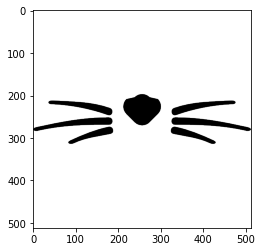

In [13]:
import matplotlib.pyplot as plt

# 원본 이미지와 콧수염 이미지 불러오기
image = cv2.imread("people.jpg")
mustache = cv2.imread("cat-whiskers.png", cv2.IMREAD_UNCHANGED)  # PNG 포맷의 투명 배경 포함 이미지

plt.imshow(mustache)
plt.show()

In [14]:
# 이미지 전처리 (그레이스케일 변환)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

In [18]:
# 이미지 전처리 (그레이스케일 변환)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# 얼굴 탐지
faces = detector_hog(gray)

for face in faces:
    # 랜드마크 추출
    landmarks = predictor(gray, face)
    landmark_points = [(p.x, p.y) for p in landmarks.parts()]
    
    # 코끝 좌표 (랜드마크 30번)
    nose_x, nose_y = landmark_points[30]
    
    # 콧수염 크기 조정 (얼굴 너비를 기준으로)
    face_width = face.width()
    resized_mustache = cv2.resize(mustache, (face_width, face_width // 4), interpolation=cv2.INTER_AREA)
    
    # 콧수염 위치 계산 (코끝 기준, 약간 아래로)
    mustache_h, mustache_w, _ = resized_mustache.shape
    x_offset = max(0, nose_x - mustache_w // 2)  # 이미지 경계 체크
    y_offset = max(0, nose_y + mustache_h // 3)

    # 이미지 합성 (알파 채널 처리)
    for i in range(mustache_h):
        for j in range(mustache_w):
            if resized_mustache[i, j, 3] > 0:  # 알파 채널이 0보다 큰 픽셀만 복사
                image[y_offset + i, x_offset + j] = resized_mustache[i, j, :3]



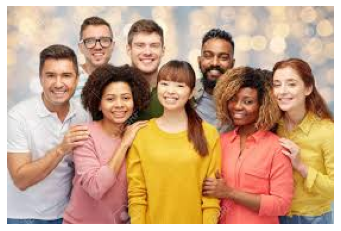

In [19]:
# 결과 저장
cv2.imwrite("output.jpg", image)

# Jupyter Notebook에서 결과 표시
output_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # OpenCV는 BGR 형식이므로 RGB로 변환
plt.imshow(output_image)
plt.axis("off")  # 축 숨기기
plt.show()

In [ ]:
# 결과 저장 및 출력
cv2.imwrite("output.jpg", image)
cv2.imshow("Result", image)
cv2.waitKey(0)
cv2.destroyAllWindows()

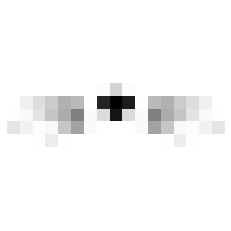

In [63]:
# 콧수염 이미지 크기
whisker_height, whisker_width = whisker_image.shape[:2]
resized_whisker = cv2.resize(whisker_image, (whisker_width // 30, whisker_height // 30), interpolation=cv2.INTER_AREA)

# Display the image
plt.imshow(resized_whisker)
plt.axis('off')
plt.show()


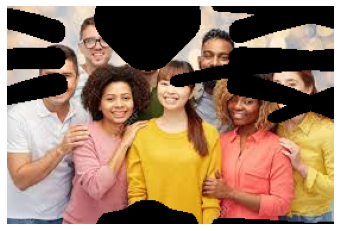

In [135]:
# Convert to grayscale for detection
gray_img = cv2.cvtColor(img_show, cv2.COLOR_BGR2GRAY)
faces = detector(gray_img)

# Composite the mustache on each detected face
for face in faces:
    # Get facial landmarks
    landmarks = predictor(gray_img, face)
    nose_x = landmarks.part(33).x  # Nose tip x-coordinate
    nose_y = landmarks.part(33).y  # Nose tip y-coordinate

    # Get top-left corner to overlay the mustache
    top_left_y = nose_y - resized_whisker.shape[0] // 2
    top_left_x = nose_x - resized_whisker.shape[1] // 2

    # Ensure the mustache fits within the image boundaries
    for i in range(resized_whisker.shape[0]):
        for j in range(resized_whisker.shape[1]):
            if top_left_y + i < img_show.shape[0] and top_left_x + j < img_show.shape[1] and top_left_y + i >= 0 and top_left_x + j >= 0:
                if resized_whisker[i, j, 3] > 0:  # Alpha channel > 0 (non-transparent)
                    img_show[top_left_y + i, top_left_x + j] = resized_whisker[i, j, :3]  # BGR values

# Convert BGR to RGB for display
img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)

# Display the image
plt.imshow(img_show_rgb)
plt.axis('off')
plt.show()


In [140]:
!pip install mediapipe

     |████████████████████████████████| 35.6 MB 4.2 MB/s            
     |████████████████████████████████| 79.6 MB 78 kB/s              
     |████████████████████████████████| 2.0 MB 56.5 MB/s            
     |████████████████████████████████| 294 kB 96.3 MB/s            
     |████████████████████████████████| 18.2 MB 58.2 MB/s            
     |████████████████████████████████| 38.6 MB 59.7 MB/s            
     |████████████████████████████████| 4.5 MB 58.2 MB/s            
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.4
    Uninstalling numpy-1.21.4:
      Successfully uninstalled numpy-1.21.4
  Attempting uninstall: scipy
    Found existing installation: scipy 1.7.1
    Uninstalling scipy-1.7.1:
      Successfully uninstalled scipy-1.7.1
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.19.1
    Uninstalling protobuf-3.19.1:
      Successfully uninstalled protobuf-3.19.1
  Attempting uninstall: flatbuffers
    Found existi

In [146]:
!pip install --upgrade protobuf

     |████████████████████████████████| 319 kB 4.5 MB/s            
  Attempting uninstall: protobuf
    Found existing installation: protobuf 4.25.5
    Uninstalling protobuf-4.25.5:
      Successfully uninstalled protobuf-4.25.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-metadata 1.5.0 requires protobuf<4,>=3.13, but you have protobuf 5.29.2 which is incompatible.
tensorflow-gpu 2.6.0 requires flatbuffers~=1.12.0, but you have flatbuffers 24.12.23 which is incompatible.
tensorflow-gpu 2.6.0 requires numpy~=1.19.2, but you have numpy 1.26.4 which is incompatible.
tensorflow-gpu 2.6.0 requires six~=1.15.0, but you have six 1.16.0 which is incompatible.
tensorflow-gpu 2.6.0 requires typing-extensions~=3.7.4, but you have typing-extensions 4.0.1 which is incompatible.
mediapipe 0.10.20 requires protobuf<5,>=4.25.3, but you have protobuf 5.29.2 whi

In [148]:
!pip install protobuf==3.20.0

     |████████████████████████████████| 1.0 MB 5.3 MB/s            
  Attempting uninstall: protobuf
    Found existing installation: protobuf 5.29.2
    Uninstalling protobuf-5.29.2:
      Successfully uninstalled protobuf-5.29.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-gpu 2.6.0 requires flatbuffers~=1.12.0, but you have flatbuffers 24.12.23 which is incompatible.
tensorflow-gpu 2.6.0 requires numpy~=1.19.2, but you have numpy 1.26.4 which is incompatible.
tensorflow-gpu 2.6.0 requires six~=1.15.0, but you have six 1.16.0 which is incompatible.
tensorflow-gpu 2.6.0 requires typing-extensions~=3.7.4, but you have typing-extensions 4.0.1 which is incompatible.
mediapipe 0.10.20 requires protobuf<5,>=4.25.3, but you have protobuf 3.20.0 which is incompatible.


In [150]:
!pip uninstall mediapipe protobuf
!pip install mediapipe protobuf==3.20.0

Found existing installation: mediapipe 0.10.20
Uninstalling mediapipe-0.10.20:
  Would remove:
    /opt/conda/lib/python3.9/site-packages/mediapipe-0.10.20.dist-info/*
    /opt/conda/lib/python3.9/site-packages/mediapipe.libs/libEGL-48f73270.so.1.1.0
    /opt/conda/lib/python3.9/site-packages/mediapipe.libs/libGLESv2-ed5eda4f.so.2.1.0
    /opt/conda/lib/python3.9/site-packages/mediapipe.libs/libGLdispatch-64b28464.so.0.0.0
    /opt/conda/lib/python3.9/site-packages/mediapipe/*
Proceed (Y/n)? ^C
ERROR: Operation cancelled by user
     |████████████████████████████████| 36.1 MB 4.4 MB/s            
     |████████████████████████████████| 35.9 MB 84.1 MB/s            
     |████████████████████████████████| 35.7 MB 52.2 MB/s            
     |████████████████████████████████| 35.6 MB 1.5 MB/s             
     |████████████████████████████████| 35.6 MB 55.4 MB/s            
  Attempting uninstall: mediapipe
    Found existing installation: mediapipe 0.10.20
    Uninstalling mediapipe-0.10

In [151]:
import mediapipe as mp
import cv2
import matplotlib.pyplot as plt  # Matplotlib for displaying images in Jupyter Notebook

# Mediapipe FaceMesh 모델 로드
mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh()

# 이미지 불러오기
image = cv2.imread("people.jpg")
if image is None:
    raise ValueError("Image not found. Check the file path.")
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# 얼굴 랜드마크 추출
results = face_mesh.process(image_rgb)

# 얼굴 랜드마크 점 그리기
if results.multi_face_landmarks:
    for landmarks in results.multi_face_landmarks:
        for landmark in landmarks.landmark:
            # 이미지 크기
            height, width, _ = image.shape

            # 좌표를 픽셀 값으로 변환
            x = int(landmark.x * width)
            y = int(landmark.y * height)

            # 각 랜드마크 좌표에 점 찍기
            cv2.circle(image, (x, y), 2, (0, 255, 0), -1)

# 결과 이미지 표시 (Jupyter Notebook에서 Matplotlib 사용)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB
plt.axis('off')  # Hide axes
plt.show()



W0000 00:00:1735137885.898908    2079 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1735137885.915094    2079 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


AttributeError: module 'google.protobuf.message_factory' has no attribute 'GetMessageClass'

In [152]:
import mediapipe as mp
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

# Mediapipe FaceMesh 모델 로드
mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh()  # 얼굴 랜드마크는 468개의 점

# 고양이 콧수염 이미지 로드 (알파 채널 포함)
whisker_image = cv2.imread('/content/drive/MyDrive/Colab Notebooks/cat-whiskers.png', cv2.IMREAD_UNCHANGED)

# 이미지 불러오기
image = cv2.imread("/content/drive/MyDrive/Colab Notebooks/image_side.jpg")
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# 얼굴 랜드마크 추출
results = face_mesh.process(image_rgb)

# 얼굴 랜드마크 점 그리기 및 콧수염 합성
if results.multi_face_landmarks:
    for landmarks in results.multi_face_landmarks:
        for landmark in landmarks.landmark:
            # 이미지 크기
            height, width, _ = image.shape

            # 좌표를 픽셀 값으로 변환
            x = int(landmark.x * width)
            y = int(landmark.y * height)

            # 각 랜드마크 좌표에 점 찍기
            cv2.circle(image, (x, y), 2, (0, 255, 0), -1)

        # 코 끝 (Tip of the nose): landmarks[1]
        center_x = int(landmarks.landmark[1].x * width)  # 코의 x좌표
        center_y = int(landmarks.landmark[1].y * height)  # 코의 y좌표

        # 고양이 콧수염 이미지 크기
        whisker_height, whisker_width = whisker_image.shape[:2]

        # 콧수염 이미지 크기 변경 (좌측은 크게, 우측은 작게)
        left_part = whisker_image[:, :whisker_width//2]  # 왼쪽 절반
        left_part_resized = cv2.resize(left_part, (whisker_width//10, whisker_height//10))  # 크기 늘리기
        right_part = whisker_image[:, whisker_width//2:]  # 오른쪽 절반
        right_part_resized = cv2.resize(right_part, (whisker_width//10, whisker_height//10))  # 크기 줄이기
        modified_whisker = np.hstack([left_part_resized, right_part_resized])

        # 콧수염을 90도 왼쪽으로 회전 (시계반대방향)
        center = (modified_whisker.shape[1] // 2, modified_whisker.shape[0] // 2)
        rotation_matrix = cv2.getRotationMatrix2D(center, 90, 1.0)  # 90도로 회전 (시계반대방향)
        rotated_whisker = cv2.warpAffine(modified_whisker, rotation_matrix, (modified_whisker.shape[1], modified_whisker.shape[0]))

        # 콧수염 이미지를 이미지에 맞게 배치
        top_left_x = int(center_x) - 40  # 수염의 X 위치
        top_left_y = int(center_y) - 15  # 수염의 Y 위치

        # 경계를 벗어나지 않도록 처리
        top_left_x = max(0, top_left_x)
        top_left_y = max(0, top_left_y)
        bottom_right_x = min(image.shape[1], top_left_x + rotated_whisker.shape[1])
        bottom_right_y = min(image.shape[0], top_left_y + rotated_whisker.shape[0])

        # 콧수염이 원본 이미지 크기를 벗어나지 않도록 잘라내기
        rotated_whisker_cropped = rotated_whisker[:bottom_right_y - top_left_y, :bottom_right_x - top_left_x]

        # 알파 채널을 기준으로 합성 (투명도를 고려)
        for i in range(rotated_whisker_cropped.shape[0]):
            for j in range(rotated_whisker_cropped.shape[1]):
                if rotated_whisker_cropped[i, j, 3] > 0:  # 알파 값이 0이 아니면
                    image[top_left_y + i, top_left_x + j] = rotated_whisker_cropped[i, j, :3]  # BGR값으로 설정

# 결과 이미지 표시
cv2_imshow(image)  # Use cv2_imshow instead of cv2.imshow
cv2.waitKey(0)
cv2.destroyAllWindows()

ModuleNotFoundError: No module named 'google.colab'